In [44]:
# Import packages for later use
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [65]:
# define johnson transformation
# def johnson(y):
#     gamma, eta, epsilon, lbda = st.johnsonsu.fit(y)
#     yt = gamma + eta * np.arcsinh((y-epsilon)/lbda)
#     return yt, gamma, eta, epsilon, lbda

# def johnson_inverse(y, gamma, eta, epsilon, lbda):
#     return lbda*np.sinh((y-gamma)/eta) + epsilon

# Get the data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data['Training'] = 1
test_data['Training'] = 0
numerical_features = train_data.dtypes[train_data.dtypes != 'object'].index.values
categorical_features = train_data.dtypes[train_data.dtypes == 'object'].index.values
omit = ['SalePrice', 'Id', 'Training']
submit = ['SalePrice', 'Id']
significant_columns_cat = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish',
 'FireplaceQu', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC',
 'MasVnrType', 'BsmtExposure', 'SaleCondition', 'Exterior1st', 'Exterior2nd',
 'SaleType', 'MSZoning', 'HouseStyle', 'GarageQual', 'GarageCond']
significant_columns_cont = [
    'OverallQual',
    'YearBuilt',
    'YearRemodAdd',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'FullBath',
    'TotRmsAbvGrd',
    'GarageYrBlt',
    'GarageCars']
significant_columns = [*significant_columns_cat, *numerical_features]
# preprocess

# drop one row in training
# train_data.dropna(subset=['Electrical'], inplace=True)

# concat
all_data = pd.concat([train_data, test_data], ignore_index=True)

# fill categoricals
categoricals = all_data[categorical_features]
categoricals.fillna('None', inplace=True)
all_data[categorical_features] = categoricals

# fill numericals with 0
all_data.fillna(0, inplace=True)

# select significant columns
all_data = all_data[significant_columns]

# add in more features
all_data['TotalSF'] = all_data['BsmtFinSF1'] + all_data['BsmtFinSF2']  + all_data['1stFlrSF']  + all_data['2ndFlrSF'] 
all_data['Bathrooms'] = all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath'] + all_data['HalfBath']) * 0.5
all_data['QualSF'] = all_data['TotalSF'] * all_data['OverallQual']
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# process non-normal feature data
# find skewness
skewness = all_data[numerical_features].apply(lambda x: st.skew(x)).sort_values(ascending=False)
print(skewness)
skewness_features = skewness[abs(skewness) > 1].index
# box-cox transform
for col in skewness_features:
    all_data[col] = boxcox1p(all_data[col], st.boxcox_normmax(all_data[col] + 1))

adjusted_skewness = all_data[skewness_features].apply(lambda x: st.skew(x))
print(adjusted_skewness)

# convert non-categorical to categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# dropping a few columns
to_drop = ['YrSold', 'MoSold', 'PoolArea']
all_data.drop(columns=to_drop, inplace=True)

# process categoricals
all_data = pd.get_dummies(data=all_data)

train_set = all_data.loc[all_data['Training'] == 1]
test_set = all_data.loc[all_data['Training'] == 0]

# obtain X & y
y = train_set['SalePrice']
y_log = np.log1p(y)
# y_j, gamma, eta, epsilon, lbda = johnson(y)
target_y = y_log

X = train_set[[c for c in train_set.columns if c not in omit]]
X_test = test_set[[c for c in test_set.columns if c not in omit]]


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
SalePrice         1.098792
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
LotFrontage       0.022013
Id                0.000000
Training         -0.000685
GarageCars       -0.219581
YearRemodAdd     -0.451020
Y

In [66]:
# create lasso model for log transformed data
alphas = np.arange(1e-5, 1e-3, 2e-6)
reg = LassoCV(cv=5, random_state=0, max_iter=50000, alphas=alphas, n_alphas=len(alphas), eps=1e-2)
    .fit(X, target_y)


0.00038599999999999995
211
61


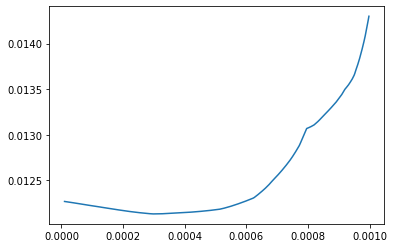

In [61]:
# Analysis for Lasso
best_alpha = reg.alpha_
coefficient = reg.coef_
non_zero_coef = [c for c in coefficient if c > 0]

print(best_alpha)
print(len(coefficient))
print(len(non_zero_coef))
mse_lasso = np.min(reg.mse_path_, axis=1)
plt.plot(alphas, mse_lasso)

In [39]:
# create xgboost cv parameter tuning
# First grid to search depth and n_estimators
xgb_model = XGBRegressor(n_jobs=1, subsample=0.8, colsample_bytree=0.5)
clf = GridSearchCV(xgb_model,
    {'max_depth': [3, 4, 5],
    'n_estimators': [500, 1000, 5000]
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_depth = clf.best_params_['max_depth']
best_n = clf.best_params_['n_estimators']

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.0min finished
{'max_depth': 3, 'n_estimators': 5000}


In [40]:
# second grid for learning rate and gamma
xgb_model = XGBRegressor(n_jobs=1, max_depth=best_depth, n_estimators=best_estimator, subsample=0.8, colsample_bytree=0.5)
clf = GridSearchCV(xgb_model,
    {'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.5, 1]
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_gamma = clf.best_params_['gamma']
best_rate = clf.best_params_['learning_rate']

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.3min finished
{'gamma': 0, 'learning_rate': 0.05}


In [67]:
# third grid to make sure everything works together
xgb_model = XGBRegressor(n_jobs=1, gamma=best_gamma, subsample=0.8, colsample_bytree=0.5)
clf = GridSearchCV(xgb_model,
    {'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4],
    'n_estimators': [5000, 10000]
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_rate = clf.best_params_['learning_rate']
best_depth = clf.best_params_['max_depth']
best_n = clf.best_params_['n_estimators']

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 28.3min finished
0.9102727247222754
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10000}


In [54]:
# Combining
splits = 5
kf = KFold(n_splits=splits)
def rmse(y1, y2):
    return np.sqrt(metrics.mean_squared_error(y1, y2))
errors_linear = []
errors_times = []

cv_trainset = train_set[[c for c in train_set.columns if c not in ['Id, Training']]]

for train, test in kf.split(cv_trainset):
    trainset = cv_trainset.iloc[train, :]
    testset = cv_trainset.iloc[test, :]
    
    train_y = np.log1p(trainset['SalePrice'])
    test_y = np.log1p(testset['SalePrice'])

    train_X = trainset[[c for c in train_set.columns if c not in omit]]
    test_X = testset[[c for c in train_set.columns if c not in omit]]
    xgb = XGBRegressor(n_jobs=1,
        gamma=best_gamma,
        subsample=0.8,
        colsample_bytree=0.5,
        learning_rate=best_rate,
        max_depth=best_depth,
        n_estimators=best_n).fit(train_X, train_y)
    y_xgb = xgb.predict(test_X)

    lasso = Lasso(random_state=0, max_iter=50000, alpha=best_alpha).fit(train_X, train_y)
    y_lasso = lasso.predict(test_X)

    # linear combination
    error_l = []
    error_m = []
    for weight in np.arange(0.05, 1, 0.05):
        y_test_final = weight * y_lasso + (1 - weight) * y_xgb
        error_l.append(rmse(test_y, y_test_final))
    errors_linear.append(error_l)

    # multiplication
    for weight in np.arange(0.05, 1, 0.05):
        y_test_final = y_lasso ** weight * y_xgb ** (1 - weight)
        error_m.append(rmse(test_y, y_test_final))
    errors_times.append(error_m)

0.3


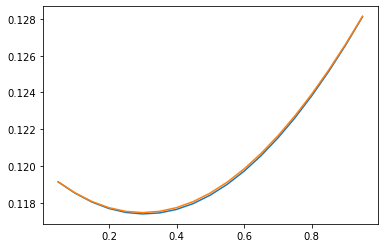

In [76]:
errors_linear_y = np.mean(errors_linear, axis=0)
errors_times_y = np.mean(errors_times, axis=0)
lasso_weights = np.arange(0.05, 1, 0.05)
plt.plot(lasso_weights, errors_times_y)
plt.plot(lasso_weights, errors_linear_y)
# Will just use linear combination
best_error = np.min(errors_linear_y)
best_w = lasso_weights[errors_linear_y == best_error][0]
print(best_w)

In [78]:
xgb = XGBRegressor(n_jobs=1,
    gamma=best_gamma,
    subsample=0.8,
    colsample_bytree=0.5,
    learning_rate=best_rate,
    max_depth=best_depth,
    n_estimators=best_n).fit(X, target_y)
lasso = Lasso(random_state=0, max_iter=50000, alpha=best_alpha).fit(X, target_y)

In [75]:
best_w[0]

0.3

In [79]:
# Prediction
y_pred_xgb = xgb.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
# y_pred = y_pred_lasso * best_w + y_pred_xgb * (1 - best_w)
y_pred = y_pred_lasso ** best_w * y_pred_xgb ** (1 - best_w)
y_final = np.exp(y_pred) - 1
test_data['SalePrice'] = y_final
submission = test_data[[c for c in test_data.columns if c in submit]]
submission.to_csv('./data/teamJarvis_lasso_xgb_v2.csv', index=False)